In [36]:
import ROOT
import uproot
import matplotlib.pyplot as plt
import numpy as np
import scipy

from lmfit import minimize, Parameters, Model
from lmfit.models import GaussianModel, ExponentialModel, \
                         ThermalDistributionModel, StepModel #Modelli vari, l'ultimo è Fermi (o Bose)

In [37]:
def load_histo(dat_PATH):
    data = np.loadtxt(dat_PATH, skiprows=0, comments='==')
    noises_edges = np.zeros((int(data.shape[0]/2), data.shape[1]))       #np.array([[]] * int(data.shape[0]/2))
    noises_values = np.zeros((int(data.shape[0]/2), data.shape[1]))       #np.array([[]] * int(data.shape[0]/2))

    for i in range(int(data.shape[0]/2)):
        noises_edges[i] = (data[2 * i])
        noises_values[i] = (data[2 * i + 1])

    return noises_edges, noises_values


def rebin(data, factor):
    if len(data) % factor != 0:
        raise ValueError("Length of data must be divisible by factor.")
    rebinned_data = np.sum(data.reshape(-1, factor), axis=1)
    return rebinned_data


In [38]:
edge_N, bin_N = load_histo("../Dati/All_noise_5M.dat")

channel = 2
edge_N = edge_N[channel]
bin_N = bin_N[channel]

rebin_fact = 1
bin_N = rebin(bin_N, rebin_fact)
tmp = []
for i in range(len(edge_N)):
    if(i % rebin_fact == 0):
        tmp.append(edge_N[i])

tmp.append(edge_N[-1])
edge_N = np.array(tmp)

centers_N = np.convolve(edge_N, [0.5, 0.5], "valid")
err_N = np.sqrt(bin_N)


Text(0, 0.5, 'counts')

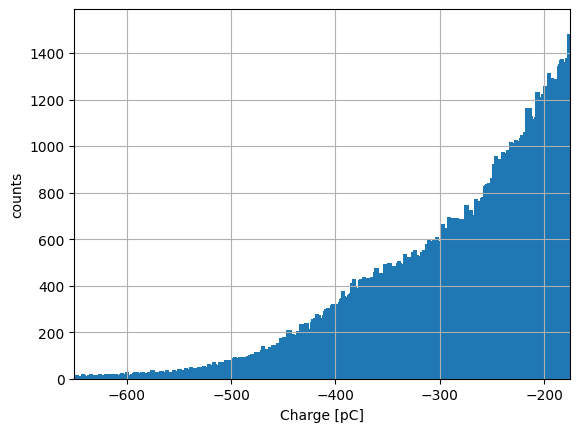

In [39]:
lim_list = [[-700, -165],  #ch0
            [-600, -155],  #ch1
            [-650, -175],  #ch2
            [-600, -145],  #ch3
            [-600, -165],  #ch4
            [-600, -175],  #ch5
            [-600, -155],  #ch6
            [-600, -180],  #ch7
            [-600, -170],  #ch8
            [-600, -160],  #ch9
            [-600, -120],  #ch10
            [-600, -165],  #ch11
            [-600, -100],  #ch12
            [-600, -100],  #ch13
            [-600, -100],  #ch14
            [-600, -100],  #ch15
            ]


lim_N = lim_list[channel]
plt.bar(centers_N, bin_N, width = 4)
plt.xlim(lim_N)
plt.grid()
plt.xlabel("Charge [pC]")
plt.ylabel("counts")

In [40]:
err_N = err_N[np.where((centers_N > lim_N[0]) & (centers_N < lim_N[1]))]
bin_N = bin_N[np.where((centers_N > lim_N[0]) & (centers_N < lim_N[1]))]
centers_N = centers_N[np.where((centers_N > lim_N[0]) & (centers_N < lim_N[1]))]

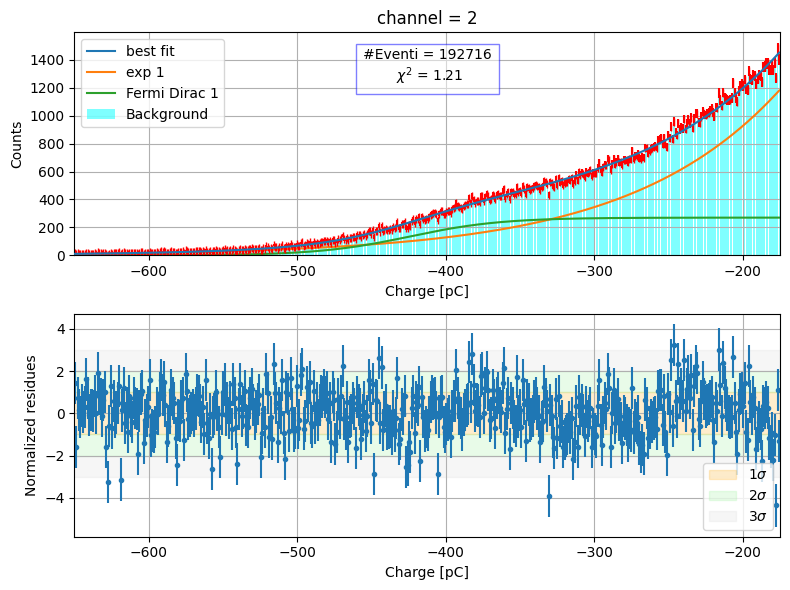

[[Model]]
    (((Model(exponential, prefix='e1_') + Model(gaussian, prefix='g1_')) + Model(step, prefix='s1_', form='logistic')) + Model(step, prefix='s2_', form='logistic'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 56
    # data points      = 490
    # variables        = 5
    chi-square         = 585.767152
    reduced chi-square = 1.20776732
    Akaike info crit   = 97.4733139
    Bayesian info crit = 118.445341
    R-squared          = 0.99999219
[[Variables]]
    e1_amplitude:  6670.58673 +/- 96.2527128 (1.44%) (init = 14485.62)
    e1_decay:     -101.311963 +/- 0.70187020 (0.69%) (init = -93.69292)
    s1_amplitude:  270.240775 +/- 7.20153364 (2.66%) (init = 100)
    s1_center:    -424.270975 +/- 1.55481915 (0.37%) (init = -412.665)
    s1_sigma:      30.5865137 +/- 1.14366191 (3.74%) (init = 67.76143)
    g1_amplitude:  0 (fixed)
    g1_center:    -320 (fixed)
    g1_sigma:      25 (fixed)
    g1_fwhm:       58.8705000 +/- 0.00000000 (0.00%) =

In [41]:
exp1   = ExponentialModel(prefix='e1_') #Esponenziale 
gauss1 = GaussianModel(prefix='g1_')    #Gaussiana
gauss2 = GaussianModel(prefix='g2_')    #Gaussiana
fd1    = ThermalDistributionModel(form = "fermi", prefix = "fd1_") #Fermi Dirac
sigmoid1 = StepModel(form = "logistic", prefix = "s1_") #Sigmoide
sigmoid2 = StepModel(form = "logistic", prefix = "s2_") #Sigmoide

 
params = exp1.guess(bin_N, x = centers_N)           #Inizializzo i parametri dell'esponenziale
params.update(sigmoid1.guess(bin_N, x=centers_N))
params.update(gauss1.make_params(amplitude = 0, center = -320, sigma = 25))   #Indovina i parametri della prima gaussiana
params.update(sigmoid2.make_params(amplitude = 0, center = -200, sigma = 50))

params["g1_amplitude"].vary = False    #Blocco i parametri della seconda gaussiana e della 
params["g1_center"].vary = False       #Fermi Dirac: non servono nel primo fit
params["g1_sigma"].vary = False
params["s2_amplitude"].vary = False
params["s2_center"].vary = False
params["s2_sigma"].vary = False

params["s1_amplitude"].min = 0
params["s1_amplitude"].value = 100

model = exp1 + gauss1 + sigmoid1 + sigmoid2  

# Fit the model to the data
result = model.fit(bin_N, params, x = centers_N, weights = 1 / err_N, nan_policy='omit')


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))
ax1.set_title(f'{channel = }')



_ = ax1.bar(centers_N, bin_N, color = "cyan", alpha = 0.5, label = "Background")
ax1.set_xlabel('Charge [pC]')
ax1.set_ylabel('Counts')
ax1.legend()
ax1.errorbar(centers_N, bin_N, err_N, color = "red", fmt='|')


comps = result.eval_components()                        #Plotto il best fit + le componenti
ax1.plot(centers_N, result.best_fit, label='best fit', zorder = 10)
ax1.plot(centers_N, comps['e1_'], label='exp 1')
ax1.plot(centers_N, comps['s1_'], label='Fermi Dirac 1')


ax1.legend()
ax1.grid()
ax1.set_xlim(lim_N)

ax1.text(np.mean(lim_N), bin_N.max(), f'#Eventi = {int(bin_N.sum())}\n $\chi^2$ = {result.redchi:.3}', 
         fontsize=10, color='black', ha = "center", va = "top", 
         bbox=dict(facecolor='white', alpha=0.5, edgecolor='blue', boxstyle='square,pad=0.5'))


residueN = bin_N - result.best_fit
norm_resN = residueN / err_N

ax2.errorbar(centers_N, norm_resN, 1, ls = "", marker = ".")
ax2.grid()

ax2.set_xlabel('Charge [pC]')
ax2.set_ylabel('Normalized residues')

xlim = ax2.get_xlim()

ax2.fill_between(xlim, [-1, -1], [1, 1], color = "orange", alpha = 0.2, label = r'$1\sigma$')
ax2.fill_between(xlim, [-2, -2], [-1, -1], color = "lightgreen", alpha = 0.2, label = r'$2\sigma$')
ax2.fill_between(xlim, [1, 1], [2, 2], color = "lightgreen", alpha = 0.2)
ax2.fill_between(xlim, [2, 2], [3, 3], color = "lightgray", alpha = 0.2, label = r'$3\sigma$')
ax2.fill_between(xlim, [-3, -3], [-2, -2], color = "lightgray", alpha = 0.2)

ax2.legend()
ax2.set_xlim(lim_N)
fig.tight_layout()
plt.show()

# Print fit statistics and parameter values
print(result.fit_report())

In [42]:
N_comp_ratio = float(result.params["e1_amplitude"].value / result.params["s1_amplitude"].value)
print(N_comp_ratio)

24.68386468561808


In [48]:
def get_noise_params(X, Y, err, mdl):
    prm = exp1.guess(Y, x = X)         
    prm.update(sigmoid1.guess(Y, x = X))

    prm["s1_amplitude"].min = 0
    prm["s1_amplitude"].value = 100

    prm.update(prm)

    rslt = mdl.fit(Y, prm, x = X, weights = 1 / err)

    exp_params = [rslt.params["e1_amplitude"].value, rslt.params["e1_decay"].value]
    fd_params = [rslt.params["s1_amplitude"].value, rslt.params["s1_sigma"].value, rslt.params["s1_center"].value]
    amp_ratio = rslt.params["e1_amplitude"].value / rslt.params["s1_amplitude"]

    return exp_params, fd_params, amp_ratio

In [49]:
edge_N, bin_N = load_histo("../Dati/All_noise_5M.dat")

for ch in range(edge_N.shape[0]):
    channel = ch

    lim_N = lim_list[ch]
    edge_N_loop = edge_N[channel]
    bin_N_loop = bin_N[channel]

    rebin_fact = 1
    bin_N_loop = rebin(bin_N_loop, rebin_fact)
    tmp = []
    for i in range(len(edge_N_loop)):
        if(i % rebin_fact == 0):
            tmp.append(edge_N_loop[i])

    tmp.append(edge_N_loop[-1])
    edge_N_loop = np.array(tmp)

    centers_N_loop = np.convolve(edge_N_loop, [0.5, 0.5], "valid")
    err_N_loop = np.sqrt(bin_N_loop)

    err_N_loop = err_N_loop[np.where((centers_N_loop > lim_N[0]) & (centers_N_loop < lim_N[1]))]
    bin_N_loop = bin_N_loop[np.where((centers_N_loop > lim_N[0]) & (centers_N_loop < lim_N[1]))]
    centers_N_loop = centers_N_loop[np.where((centers_N_loop > lim_N[0]) & (centers_N_loop < lim_N[1]))]

   


    print(get_noise_params(centers_N_loop, bin_N_loop, err_N_loop, model))


([6003.474820164097, -98.31200084825305], [199.1423097069584, 25.490089781572923, -422.9717292148343], 30.146656574378)
([6846.494114352459, -87.17446112563617], [247.8568532109945, 23.982464983797982, -383.3654082782889], 27.622775104484223)
([6670.586732557363, -101.31196284314979], [270.24077540191445, 30.58651373486296, -424.2709749734387], 24.68386468561808)
([9278.095087038893, -96.82657098431719], [377.58875399557047, 23.75511944217029, -403.6146423577553], 24.571958218723154)
([10071.524896618092, -86.87934254370674], [319.75945105202646, 20.967354965133936, -390.10027627536823], 31.49719222835232)
([9289.040832323357, -88.68390560858653], [322.38999038819105, 21.71882308914338, -391.6172282248534], 28.813055954803023)
([7448.132339242812, -88.26180534265832], [203.93936230675945, 27.08134452555478, -406.8542737532541], 36.52130836831566)
([8834.603291843958, -89.37712207575227], [326.86099844302964, 24.043687951644447, -400.8319964879808], 27.028624809710323)
([8107.1959967025